In [1]:
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import cm
import matplotlib.cbook as cbook
import matplotlib.colors as colors

import pandas as pd
import xarray as xr
from netCDF4 import Dataset, num2date, date2num
from datetime import datetime, timedelta
import os

%matplotlib inline

In [2]:
latList = [-9, -8, -5, -2, 0, 2, 5, 8, 9]
lonList = [-95, -110, -125, -140, -155, -170, -180, 165]

ylen = len(latList)
xlen = len(lonList)

taskList = []

for latId  in range(ylen):
    for lonId in range(xlen):
        taskList.append([latList[latId], lonList[lonId]])

ntasks = len(taskList)

i = 0
tlen = 0

metaData = np.empty((0,20), dtype=float)
metaDataIndex = ['time',
                 'lat', 
                 'lon',
                 'U10N_QS',
                 'U10N_dir_QS',
                 'satTimeDiff',
                 'dist',
                 'satLon',
                 'satLat',
                 'U10N_TAO',
                 'U10N_dir_TAO',
                 'U10N_TAO2',
                 'U10N_dir_TAO2',
                 'U10N_x_TAO2',
                 'U10N_y_TAO2',
                 'SST_TAO',
                 'RH_TAO',
                 'AIRT_TAO',
                 'wspdVar2hr_TAO',
                 'Deployment Classifier']

for task in taskList:
    lat = task[0]
    lon = task[1]

    LAT = lat
    LON = lon

    if lat < 0:
        latUnits = 'S'
    else:
        latUnits = 'N'

    if lon < 0:
        lonUnits = 'W'
        LON += 360
    else:
        lonUnits = 'E'
    
    lat=abs(lat)
    lon=abs(lon)

    matchFname = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_matchupNearestFour_2000.nc'
    deployFileName = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_DeploymentDates.nc'
    
    if os.path.isfile(matchFname):

        ds = Dataset(matchFname)
        arr = np.empty((0,1), dtype=float)
        for i in range(3,19):
            if i <= 8:
                #print(i, metaDataIndex[i])
                readArr = np.array([ds.variables[metaDataIndex[i]][0,:]]).T
                #print(readArr.shape)
                #print(arr.shape)
                if len(arr) == 0:
                    arr = np.concatenate((arr, readArr), axis = 0)
                else:
                    arr = np.concatenate((arr, readArr), axis = 1)
            else:
                #print(i, metaDataIndex[i])
                readArr = np.array([ds.variables[metaDataIndex[i]][:]]).T
                #print(readArr.shape)
                #print(arr.shape)
                arr = np.concatenate((arr, readArr), axis = 1)

        latArr = np.array([len(arr)*[LAT]]).T
        lonArr = np.array([len(arr)*[LON]]).T
        timeArr = np.array(ds.variables['time'])

        # latArr = latArr[:,np.newaxis]
        # lonArr = lonArr[:,np.newaxis]
        timeArr = timeArr[:,np.newaxis]
        
        #print('lonArr', lonArr.shape)
        arr = np.concatenate((lonArr, arr), axis=1)

        #print('latArr', latArr.shape)
        arr = np.concatenate((latArr, arr), axis=1)

        #print('timeArr', timeArr.shape)
        arr = np.concatenate((timeArr, arr), axis=1)

        ds2 = Dataset(deployFileName)
        startDates = np.array(ds2.variables['startDate'])
        endDates = np.array(ds2.variables['endDate'])

        depNum = np.zeros((len(arr),1), dtype=int)
        c = 1
        for i in range(1,len(startDates)):
            mask = timeArr >= startDates[i]
            mask *= timeArr <= endDates[i]
            depNum[mask] = c
            c = c+1

        arr = np.concatenate((arr, depNum), axis=1)


        metaData = np.concatenate((metaData, arr), axis=0)
        #ds = ds.expand_dims('lat', axis= 0)
        



In [3]:
nanVals = np.sum(metaData[:,:-2], axis=1)
mask = np.isnan(nanVals)
print(np.sum(mask), metaData.shape)
metaData = metaData[~mask, :]
print(metaData.shape)

7925 (199639, 20)
(191714, 20)


In [4]:
df = pd.DataFrame(metaData, columns = metaDataIndex )
df['speedDiff'] = df['U10N_QS'] - df['U10N_TAO']
df['absSpeedDiff'] = abs(df['U10N_QS'] - df['U10N_TAO'])

dDiff = (df['U10N_dir_QS'] - df['U10N_dir_TAO'])%360
dDiff[dDiff > 180] -= 360 #- dDiff[dDiff > 180] 
dDiff[dDiff < -180] += 360
df['directionDiff'] = dDiff
df['absDirectionDiff'] = abs(dDiff)

In [5]:
df

,time,lat,lon,U10N_QS,U10N_dir_QS,satTimeDiff,dist,satLon,satLat,U10N_TAO,...,U10N_y_TAO2,SST_TAO,RH_TAO,AIRT_TAO,wspdVar2hr_TAO,Deployment Classifier,speedDiff,absSpeedDiff,directionDiff,absDirectionDiff
0,315534600.0,-8.0,265.0,5.747140,325.648834,276.0,6.455491,265.053436,-7.976122,5.926161,...,4.936657,23.745001,73.830002,22.930000,NaN,0.0,-0.179021,0.179021,-0.751160,0.751160
1,315535200.0,-8.0,265.0,5.747140,325.648834,-324.0,6.455491,265.053436,-7.976122,5.836925,...,4.592328,23.743000,73.300003,22.840000,NaN,0.0,-0.089785,0.089785,3.848846,3.848846
2,315704400.0,-8.0,265.0,6.211579,323.708984,271.0,6.615148,264.974976,-7.945916,5.541527,...,4.321145,23.938000,75.730003,23.200001,0.242370,0.0,0.670052,0.670052,2.408997,2.408997
3,315705000.0,-8.0,265.0,6.211579,323.708984,-329.0,6.615148,264.974976,-7.945916,5.992860,...,4.631890,23.927999,75.599998,23.190001,0.257944,0.0,0.218719,0.218719,3.108978,3.108978
4,315749400.0,-8.0,265.0,5.837174,318.623627,457.0,5.688329,265.045563,-7.975894,6.055364,...,4.486742,23.716999,73.879997,23.040001,0.153811,0.0,-0.218190,0.218190,0.823639,0.823639
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191709,536339400.0,9.0,220.0,9.060904,251.005539,-42.0,6.435526,219.981033,8.945240,6.371357,...,-3.741454,26.754999,94.370003,25.299999,1.573013,10.0,2.689547,2.689547,17.005539,17.005539
191710,536384400.0,9.0,220.0,10.913956,239.481735,86.0,0.888303,219.992020,9.001301,10.637788,...,-6.623943,26.757000,88.559998,26.260000,0.264562,10.0,0.276167,0.276167,7.981735,7.981735
191711,536385000.0,9.0,220.0,10.913956,239.481735,-514.0,0.888303,219.992020,9.001301,10.480252,...,-6.413253,26.754999,88.000000,26.270000,0.341049,10.0,0.433704,0.433704,7.181732,7.181732
191712,536424000.0,9.0,220.0,10.722863,244.993149,205.0,1.812441,219.997299,8.983920,11.739903,...,-6.895950,26.660999,93.629997,25.110001,0.536636,10.0,-1.017040,1.017040,10.993149,10.993149


In [6]:
selectX = [#'time',
           #'U10N_QS',
           #'U10N_dir_QS',
           #'satTimeDiff',
           #'dist',
           #'U10N_TAO',
           #'U10N_dir_TAO',
           #'U10N_x_TAO2',
           #'U10N_y_TAO2',
           #'SST_TAO',
           #'RH_TAO',
           #'AIRT_TAO',
           'speedDiff',
           'directionDiff',
           #'absSpeedDiff',
           #'absDirectionDiff'
            ]

X = df[selectX]

In [7]:
X.head()

,speedDiff,directionDiff
0,-0.179021,-0.751160
1,-0.089785,3.848846
2,0.670052,2.408997
3,0.218719,3.108978
4,-0.218190,0.823639


In [8]:
normX = (X - X.mean(axis=0))/ X.std(axis=0)

In [9]:
normX

,speedDiff,directionDiff
0,-0.301462,-0.033003
1,-0.230791,0.115771
2,0.370973,0.069203
3,0.013534,0.091842
4,-0.332482,0.017929
...,...,...
191709,1.970340,0.541285
191710,0.059031,0.249437
191711,0.183794,0.223563
191712,-0.965143,0.346832


In [10]:
# normX['errorFrmNorm'] = np.sqrt(normX['absSpeedDiff']**2 + normX['absDirectionDiff']**2)
# X=normX['errorFrmNorm']

In [11]:
# Y = X.to_numpy()

In [12]:
# Y = np.array([Y]).transpose()
# Y.shape

(0.20163199763732254, 1.2626835966203092, 0.844967012745474)

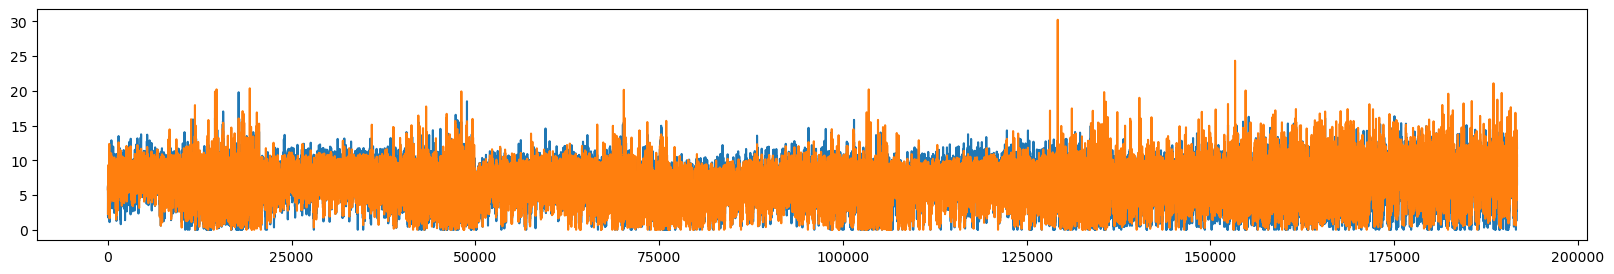

In [13]:
n1= 0
n2 = -1
plt.figure(figsize=(20,3))
plt.plot(df['U10N_TAO'][n1:n2])
plt.plot(df['U10N_QS'][n1:n2])
np.mean(df['U10N_QS'][n1:n2]-df['U10N_TAO'][n1:n2]), np.std(df['U10N_QS'][n1:n2]-df['U10N_TAO'][n1:n2]), np.corrcoef(df['U10N_TAO'][n1:n2], df['U10N_QS'][n1:n2])[0,1]

(6.118572893833565, 58.381158007122366, 0.6913673845777532)

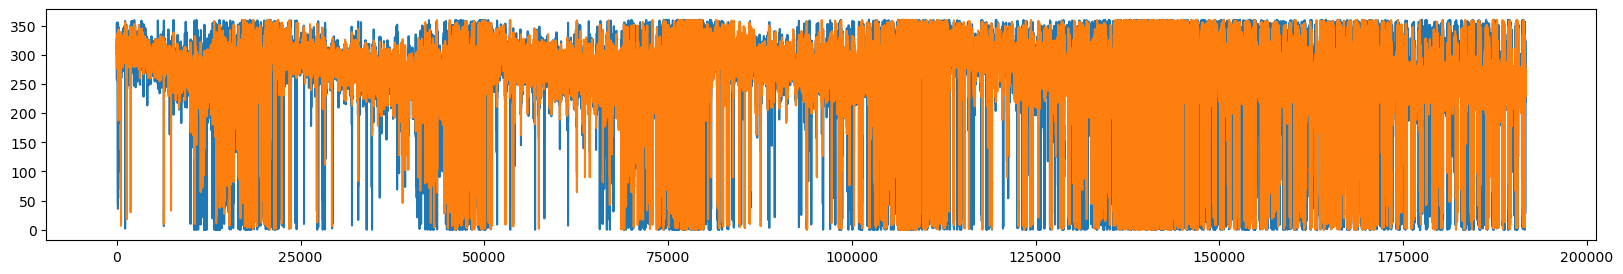

In [14]:
n1= 0
n2 = -1
plt.figure(figsize=(20,3))
plt.plot(df['U10N_dir_TAO'][n1:n2])
plt.plot(df['U10N_dir_QS'][n1:n2])
np.mean(df['U10N_dir_QS'][n1:n2]-df['U10N_dir_TAO'][n1:n2]), np.std(df['U10N_dir_QS'][n1:n2]-df['U10N_dir_TAO'][n1:n2]), np.corrcoef(df['U10N_dir_TAO'][n1:n2], df['U10N_dir_QS'][n1:n2])[0,1]

In [15]:
kmeans = KMeans(n_clusters=9, random_state=0, n_init="auto", max_iter = 10000).fit(normX)
df['label'] = kmeans.labels_

In [16]:
def plotTimeSeriesByClusterLabel(df, lat, lon, ax1, ax2, cluster_label=0, color='blue'):
    subDF = df.loc[df['lat'] == lat]
    subDF = subDF.loc[subDF['lon'] == lon%360]
    subDF = subDF.loc[subDF['label'] == cluster_label]

    if lat < 0:
        latUnits = 'S'
        lat = abs(lat)
    else:
        latUnits = 'N'

    if lon < 0:
        lonUnits = 'W'
        lon = abs(lon) # 360
    else:
        lonUnits = 'E'

    
    deployFileName = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_DeploymentDates.nc'
    ds2 = Dataset(deployFileName)
    startDates = np.array(ds2.variables['startDate'])
    units = ds2.variables['startDate'].units
    cftimes = num2date(startDates, units)
    startDates = np.array([datetime(dtm.year, dtm.month, dtm.day, dtm.hour, dtm.minute, dtm.second) for dtm in cftimes])

    endDates = np.array(ds2.variables['endDate'])
    units = ds2.variables['endDate'].units
    cftimes = num2date(endDates, units)
    endDates = np.array([datetime(dtm.year, dtm.month, dtm.day, dtm.hour, dtm.minute, dtm.second) for dtm in cftimes])

    ds2.close()
    
    cftimes = num2date(subDF['time'], 'seconds since 1990-01-01 00:00:00')
    dates = np.array([datetime(dtm.year, dtm.month, dtm.day, dtm.hour, dtm.minute) for dtm in cftimes])
    y1 = subDF['speedDiff']
    y2 = subDF['directionDiff']

    for i in range(len(startDates)):
        colorR =list(np.random.choice(range(256), size=3)/256)
        
        ax1.axvspan(startDates[i], endDates[i], 
                   alpha=0.05, color=colorR)
        ax2.axvspan(startDates[i], endDates[i], 
                   alpha=0.05, color=colorR)
    
    #ax1.scatter(subDF['time'], y1, s=2, label = cluster_label)#, c = subDF['label'])
    #ax2.scatter(subDF['time'], y2, s=2, label = cluster_label)#, c = subDF['label'])

    ax1.scatter(dates, y1, s=3, label = cluster_label, c = color)
    ax2.scatter(dates, y2, s=3, label = cluster_label, c = color)
    ax1.set_title(f'{lat:02d}{latUnits} {lon:03d}{lonUnits} speed Diff')
    ax2.set_title(f'{lat:02d}{latUnits} {lon:03d}{lonUnits} direction Diff')

def plotTimeSeriesAllClusterLabel(df, lat, lon, ax1, ax2):
    subDF = df.loc[df['lat'] == lat]
    subDF = subDF.loc[subDF['lon'] == lon%360]
    
    
    dates = num2date(subDF['time'], 'seconds since 1990-01-01 00:00:00')

    y1 = subDF['speedDiff']
    y2 = subDF['directionDiff']
    
    ax1.scatter(subDF['time'], y1, s=2, c = subDF['Deployment Classifier'], cmap='prism')
    ax2.scatter(subDF['time'], y2, s=2, c = subDF['Deployment Classifier'], cmap='prism')

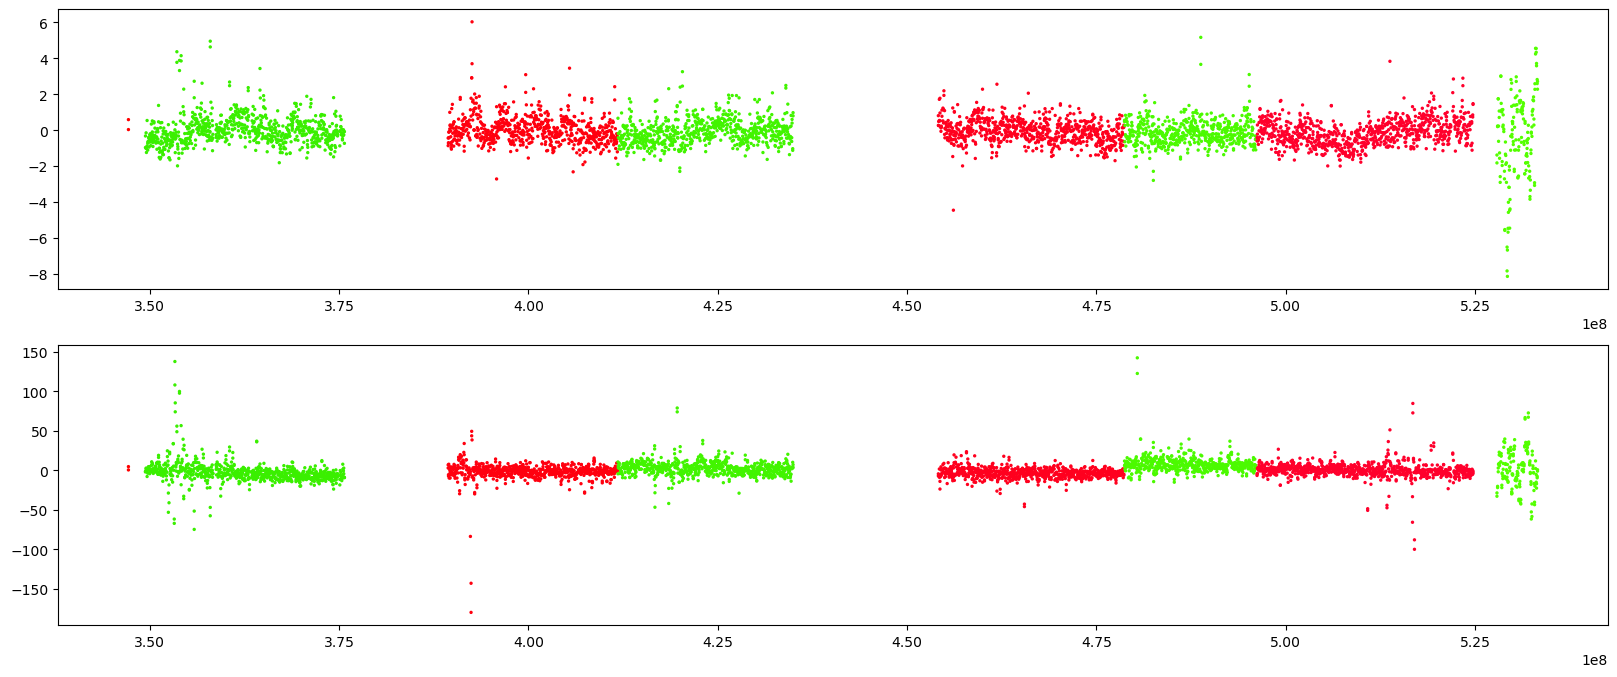

In [17]:
lat = -2
lon = -140

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20,8))
plotTimeSeriesAllClusterLabel(df, lat, lon, axes[0], axes[1])

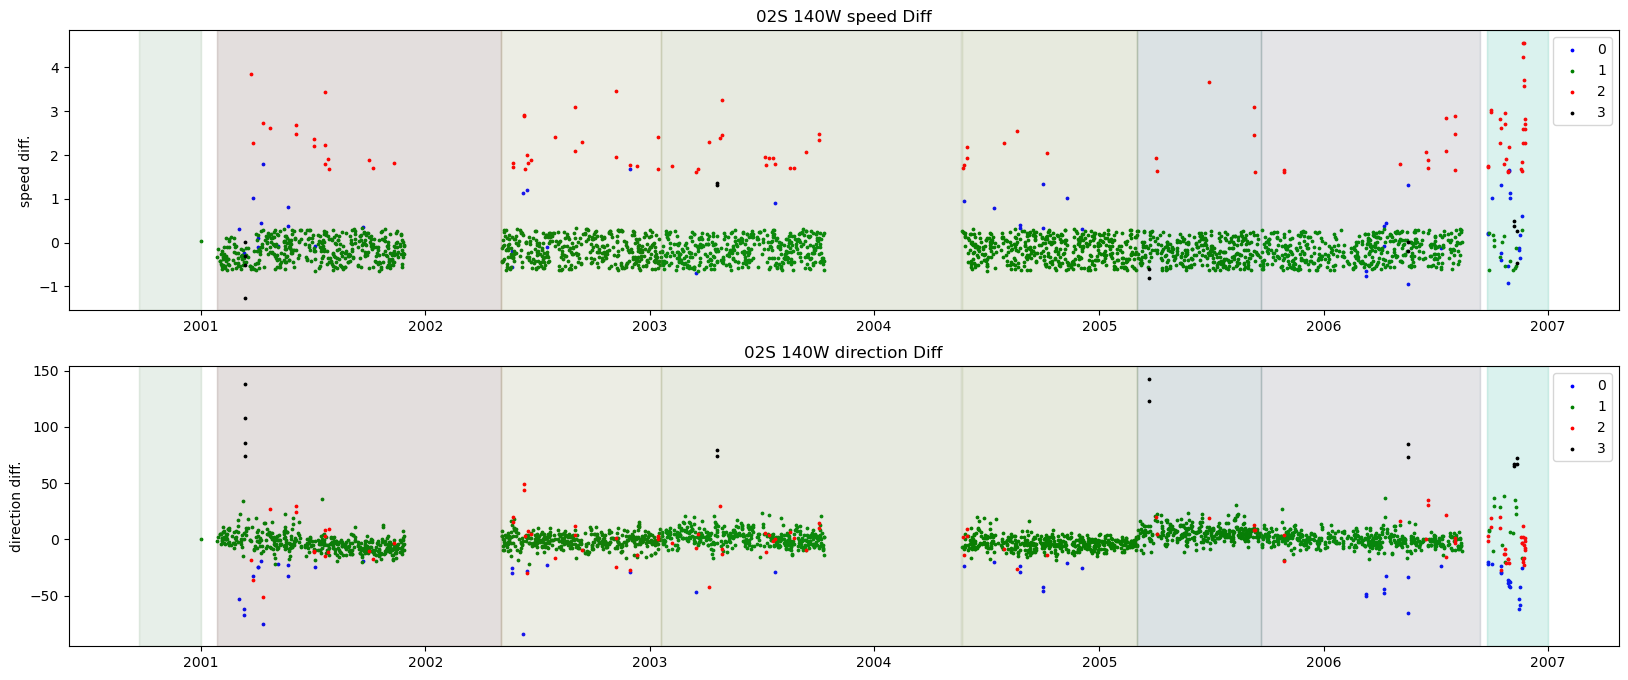

In [18]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20,8))
plotTimeSeriesByClusterLabel(df, lat, lon, axes[0], axes[1], cluster_label=0, color = 'blue')
plotTimeSeriesByClusterLabel(df, lat, lon, axes[0], axes[1], cluster_label=1, color = 'green')
plotTimeSeriesByClusterLabel(df, lat, lon, axes[0], axes[1], cluster_label=2, color = 'red')
plotTimeSeriesByClusterLabel(df, lat, lon, axes[0], axes[1], cluster_label=3, color = 'black')
# plotTimeSeriesByClusterLabel(df, lat, lon, axes[0], axes[1], cluster_label=4)
# plotTimeSeriesByClusterLabel(df, lat, lon, axes[0], axes[1], cluster_label=5)
# plotTimeSeriesByClusterLabel(df, lat, lon, axes[0], axes[1], cluster_label=6)
# plotTimeSeriesByClusterLabel(df, lat, lon, axes[0], axes[1], cluster_label=7)
# plotTimeSeriesByClusterLabel(df, lat, lon, axes[0], axes[1], cluster_label=8)
# plotTimeSeriesByClusterLabel(df, lat, lon, axes[0], axes[1], cluster_label=9)
axes[0].set_ylabel('speed diff.')
axes[0].legend()

axes[1].set_ylabel('direction diff.')
axes[1].legend()

In [19]:
df.head()

,time,lat,lon,U10N_QS,U10N_dir_QS,satTimeDiff,dist,satLon,satLat,U10N_TAO,...,SST_TAO,RH_TAO,AIRT_TAO,wspdVar2hr_TAO,Deployment Classifier,speedDiff,absSpeedDiff,directionDiff,absDirectionDiff,label
0,315534600.0,-8.0,265.0,5.747140,325.648834,276.0,6.455491,265.053436,-7.976122,5.926161,...,23.745001,73.830002,22.930000,NaN,0.0,-0.179021,0.179021,-0.751160,0.751160,1
1,315535200.0,-8.0,265.0,5.747140,325.648834,-324.0,6.455491,265.053436,-7.976122,5.836925,...,23.743000,73.300003,22.840000,NaN,0.0,-0.089785,0.089785,3.848846,3.848846,1
2,315704400.0,-8.0,265.0,6.211579,323.708984,271.0,6.615148,264.974976,-7.945916,5.541527,...,23.938000,75.730003,23.200001,0.242370,0.0,0.670052,0.670052,2.408997,2.408997,7
3,315705000.0,-8.0,265.0,6.211579,323.708984,-329.0,6.615148,264.974976,-7.945916,5.992860,...,23.927999,75.599998,23.190001,0.257944,0.0,0.218719,0.218719,3.108978,3.108978,1
4,315749400.0,-8.0,265.0,5.837174,318.623627,457.0,5.688329,265.045563,-7.975894,6.055364,...,23.716999,73.879997,23.040001,0.153811,0.0,-0.218190,0.218190,0.823639,0.823639,1


In [20]:
import seaborn as sns

In [21]:
#sns.pairplot(data=df, x = 'hue="label")

In [22]:
subDFheaders = ['satTimeDiff',
                 'dist',
                 'SST_TAO',
                 'RH_TAO',
                 'AIRT_TAO',
                 'speedDiff',
                 'directionDiff',
                 'absSpeedDiff',
                 'absDirectionDiff',
                 'label']

subDFheaders = [ 'satTimeDiff',
                 'dist',
                 # 'SST_TAO',
                 # 'RH_TAO',
                 # 'AIRT_TAO',
                 'speedDiff',
                 'directionDiff',
                 #'absSpeedDiff',
                 #'absDirectionDiff',
                 'label']

subDF = df[subDFheaders]

In [23]:
#snsPlot = sns.pairplot(data=subDF, hue="label")

In [24]:
#snsPlot.figure.savefig('allData.png', dpi = 100)

In [25]:
# g = sns.PairGrid(subDF, hue="label", palette = sns.color_palette("bright"), corner=True)
# g.map_lower(sns.kdeplot, common_norm=False, levels=20, linewidths=0.75)
# g.map_diag(sns.histplot, common_norm=False, element="step", linewidth=0, kde=True)
# g.add_legend(frameon=True)
# g.legend.set_bbox_to_anchor((.61, .6))
# g.figure.savefig('allDataProbDensityClusteringJustByErrorsCommonNormFalse.png', dpi = 100)

In [26]:
# g = sns.PairGrid(subDF, hue="label", palette = sns.color_palette("bright"), corner=True)
# g.map_lower(sns.kdeplot, common_norm=False, levels=20, linewidths=0.75)
# g.map_diag(sns.histplot, common_norm=False, element="step", linewidth=0, kde=True)
# g.add_legend(frameon=True)
# g.legend.set_bbox_to_anchor((.61, .6))
# g.figure.savefig('timeAndSpaceDistProbDensityClusteringJustByErrorsCommonNormFalse.png', dpi = 100)

In [27]:
# g = sns.PairGrid(subDF, hue="label", palette = sns.color_palette("bright"), corner=True)
# g.map_lower(sns.kdeplot, common_norm=True, levels=20, linewidths=0.75)
# g.map_diag(sns.histplot, common_norm=True, element="step", linewidth=0, kde=True)
# g.add_legend(frameon=True)
# g.legend.set_bbox_to_anchor((.61, .6))
# g.figure.savefig('allDataProbDensityClusteringJustByErrorsCommonNormTrue.png', dpi = 100)

In [28]:
# g = sns.PairGrid(subDF, hue="label", palette = sns.color_palette("bright"), corner=True)
# g.map_lower(sns.kdeplot, common_norm=True, levels=20, linewidths=0.75)
# g.map_diag(sns.histplot, common_norm=True, element="step", linewidth=0, kde=True)
# g.add_legend(frameon=True)
# g.legend.set_bbox_to_anchor((.61, .6))
# g.figure.savefig('timeAndSpaceDistProbDensityClusteringJustByErrorsCommonNormTrue.png', dpi = 100)

In [29]:
# xlabel = 'directionDiff'
# s = sns.kdeplot(subDF, x=xlabel, 
#                 hue='label', common_norm=False,
#                 palette = sns.color_palette("bright"))

In [30]:
# xlabel = 'speedDiff'
# s = sns.kdeplot(subDF, x=xlabel, 
#                 hue='label', common_norm=False,
#                 palette = sns.color_palette("bright"))

In [31]:
# xlabel = 'absSpeedDiff'
# ylabel = 'absDirectionDiff'
# s = sns.kdeplot(df, x=xlabel, y = ylabel,levels=10, 
#                 hue='label', common_norm=False,
#                 palette = sns.color_palette("bright"))

In [32]:
# xlabel = 'speedDiff'
# ylabel = 'directionDiff'
# s = sns.kdeplot(df, x=xlabel, y = ylabel,levels=10, 
#                 hue='label', common_norm=False,
#                 palette = sns.color_palette("bright"))

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

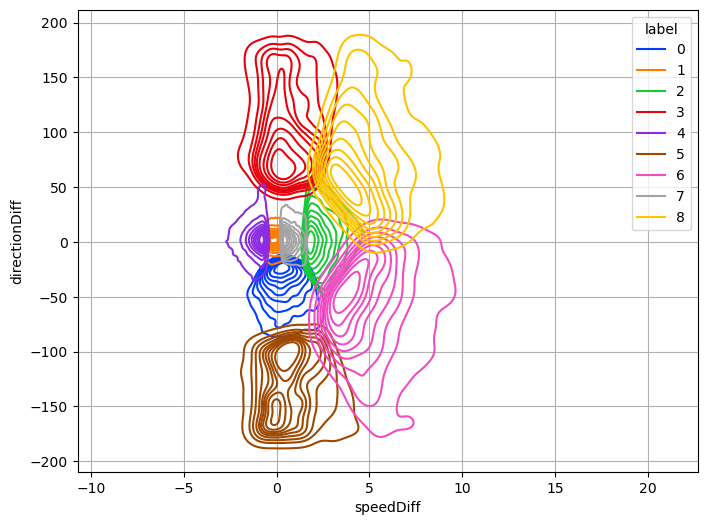

In [33]:
fig,  ax = plt.subplots(figsize=(8,6))
xlabel = 'speedDiff'
ylabel = 'directionDiff'
s = sns.kdeplot(df, x=xlabel, y = ylabel,levels=10, 
                hue='label', common_norm=False,
                palette = sns.color_palette("bright"), ax = ax)

ax.grid(visible=True, which='both', axis='both')

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

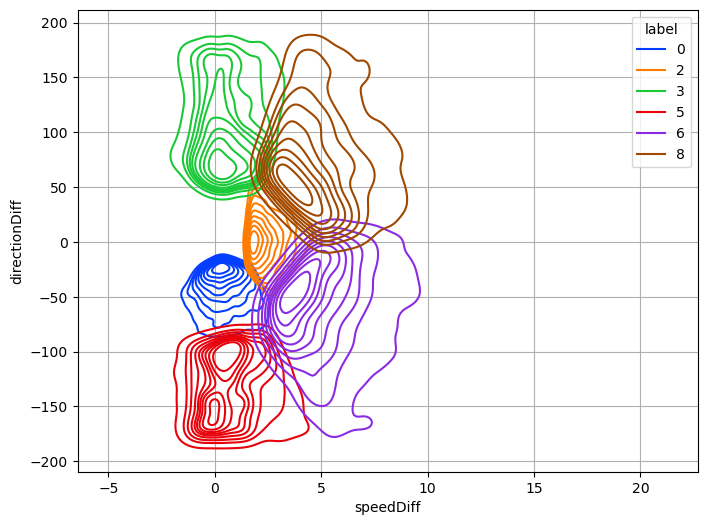

In [34]:
fig,  ax = plt.subplots(figsize=(8,6))
xlabel = 'speedDiff'
ylabel = 'directionDiff'
subdf = df.loc[df['label'].isin([0,2,3,5,6,8])]
s = sns.kdeplot(subdf, x=xlabel, y = ylabel,levels=10, 
                hue='label', common_norm=False,
                palette = sns.color_palette("bright"), ax = ax)

ax.grid(visible=True, which='both', axis='both')

In [ ]:
sns.set_style("whitegrid")
tips = sns.load_dataset("tips")
box_plot = sns.boxplot(x="day",y="total_bill",data=tips)

medians = tips.groupby(['day'])['total_bill'].median()
vertical_offset = tips['total_bill'].median() * 0.05 # offset from median for display

for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians[xtick] + vertical_offset,medians[xtick], 
            horizontalalignment='center',size='x-small',color='w',weight='semibold')

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


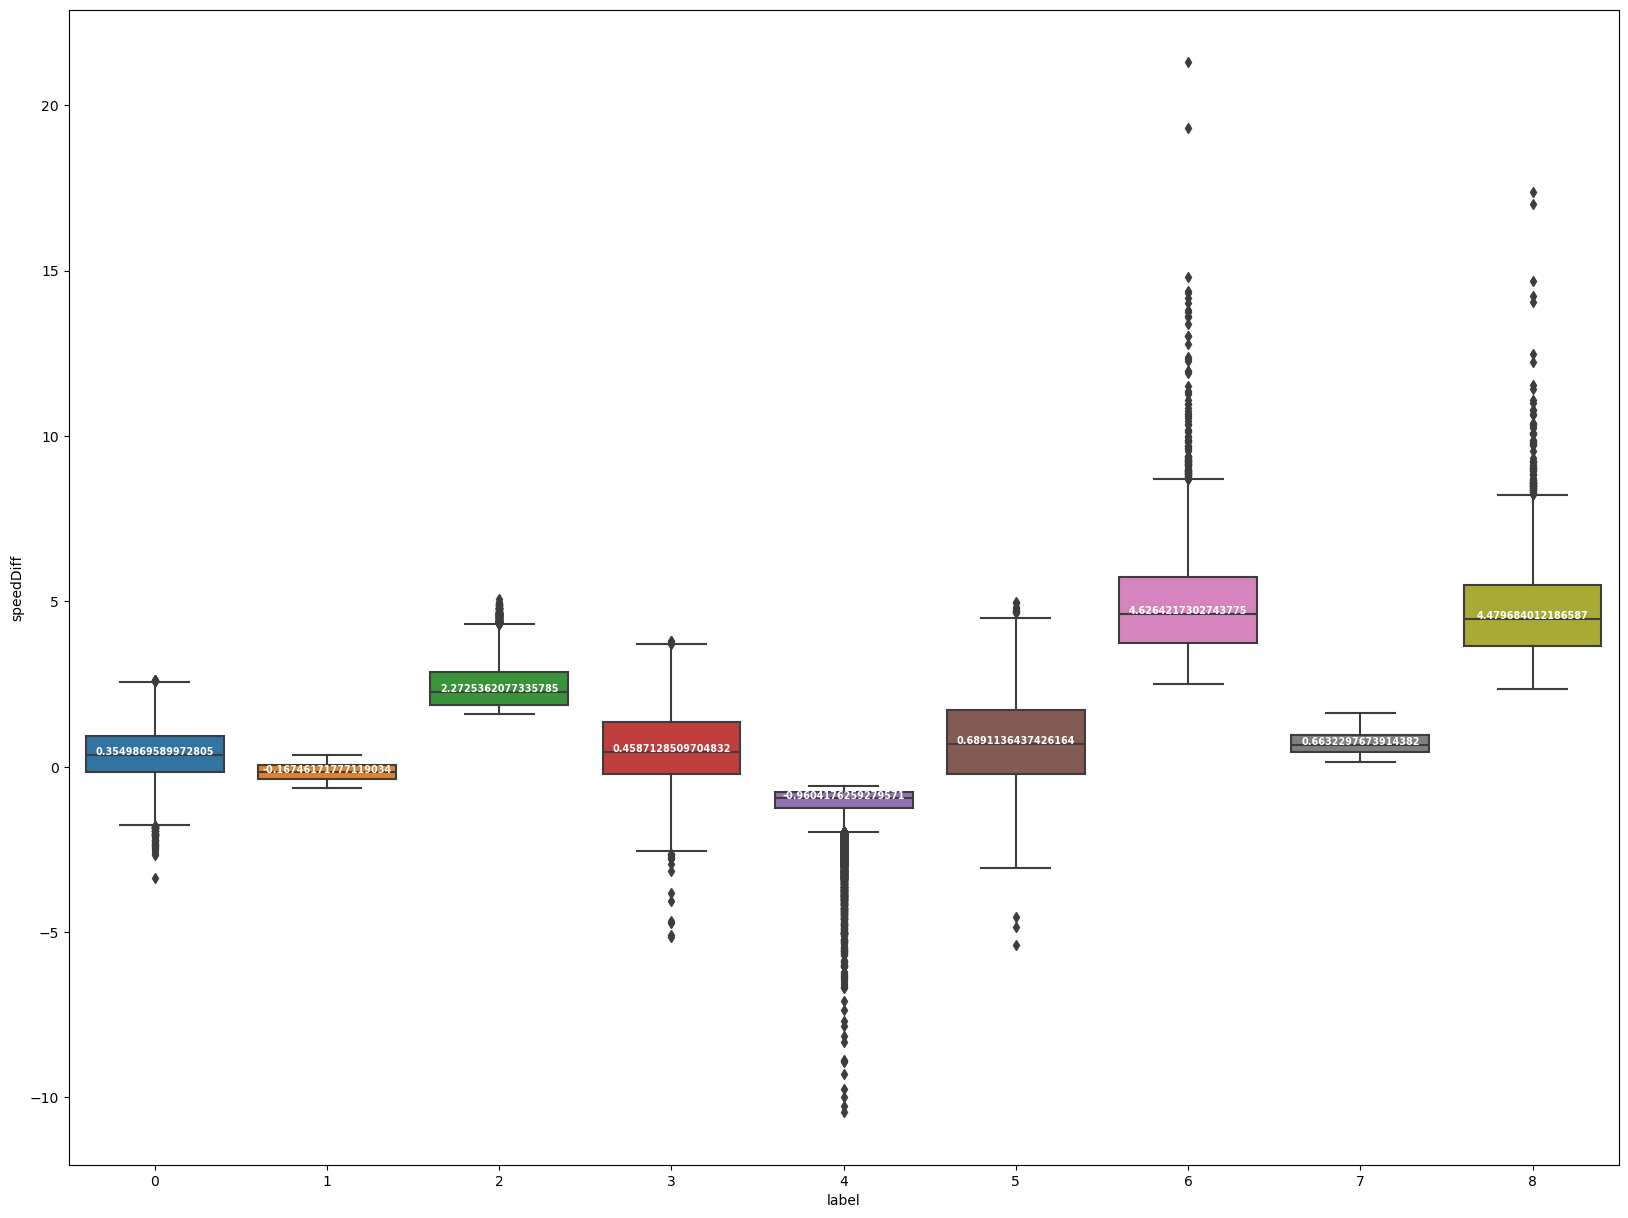

In [27]:
fig, ax = plt.subplots(figsize = (20,15))
box_plot = sns.boxplot(df, x="label",y="speedDiff", ax = ax)

medians = df.groupby(['label'])['speedDiff'].median()
vertical_offset = df['speedDiff'].median() * 0.05 # offset from median for display

for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians[xtick] + vertical_offset,medians[xtick], 
            horizontalalignment='center',size='x-small',color='w',weight='semibold')

In [82]:
var = 'speedDiff'
labelVal = 0

def getPDFplotFor(ax, df, labelVal, var):
    sns.histplot(df.loc[df['label'] == labelVal], x = var, ax = ax, bins = 50)
    ax.axvline(x = medians[labelVal], ymin= 0 , ymax = 0.25, color = 'r',  label = 'median')
    ax.axvline(x = means[labelVal], ymin= 0 , ymax = 0.25, color = 'blue',linestyle = '--', label = 'mean')
    ax.axvline(x = means[labelVal]-stdDevs[labelVal],  ymin= 0 , ymax = 0.25, color = 'orange', label = 'std. Dev')
    ax.axvline(x = means[labelVal]+stdDevs[labelVal],  ymin= 0 , ymax = 0.25, color = 'orange')
    
    text = f' mean: {means[labelVal]:6.2f} \n median: {medians[labelVal]:6.2f} \n stdDev: {stdDevs[labelVal]:6.2f}'
    
    
    ax.text(0.05, 0.95, text, horizontalalignment='left',
         verticalalignment='top', transform=ax.transAxes,
         bbox=dict(facecolor='white', alpha= 0.5))
    ax.legend(loc='upper right')

0 0
0 1
0 2
0 3
1 0


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option i

1 1
1 2
1 3


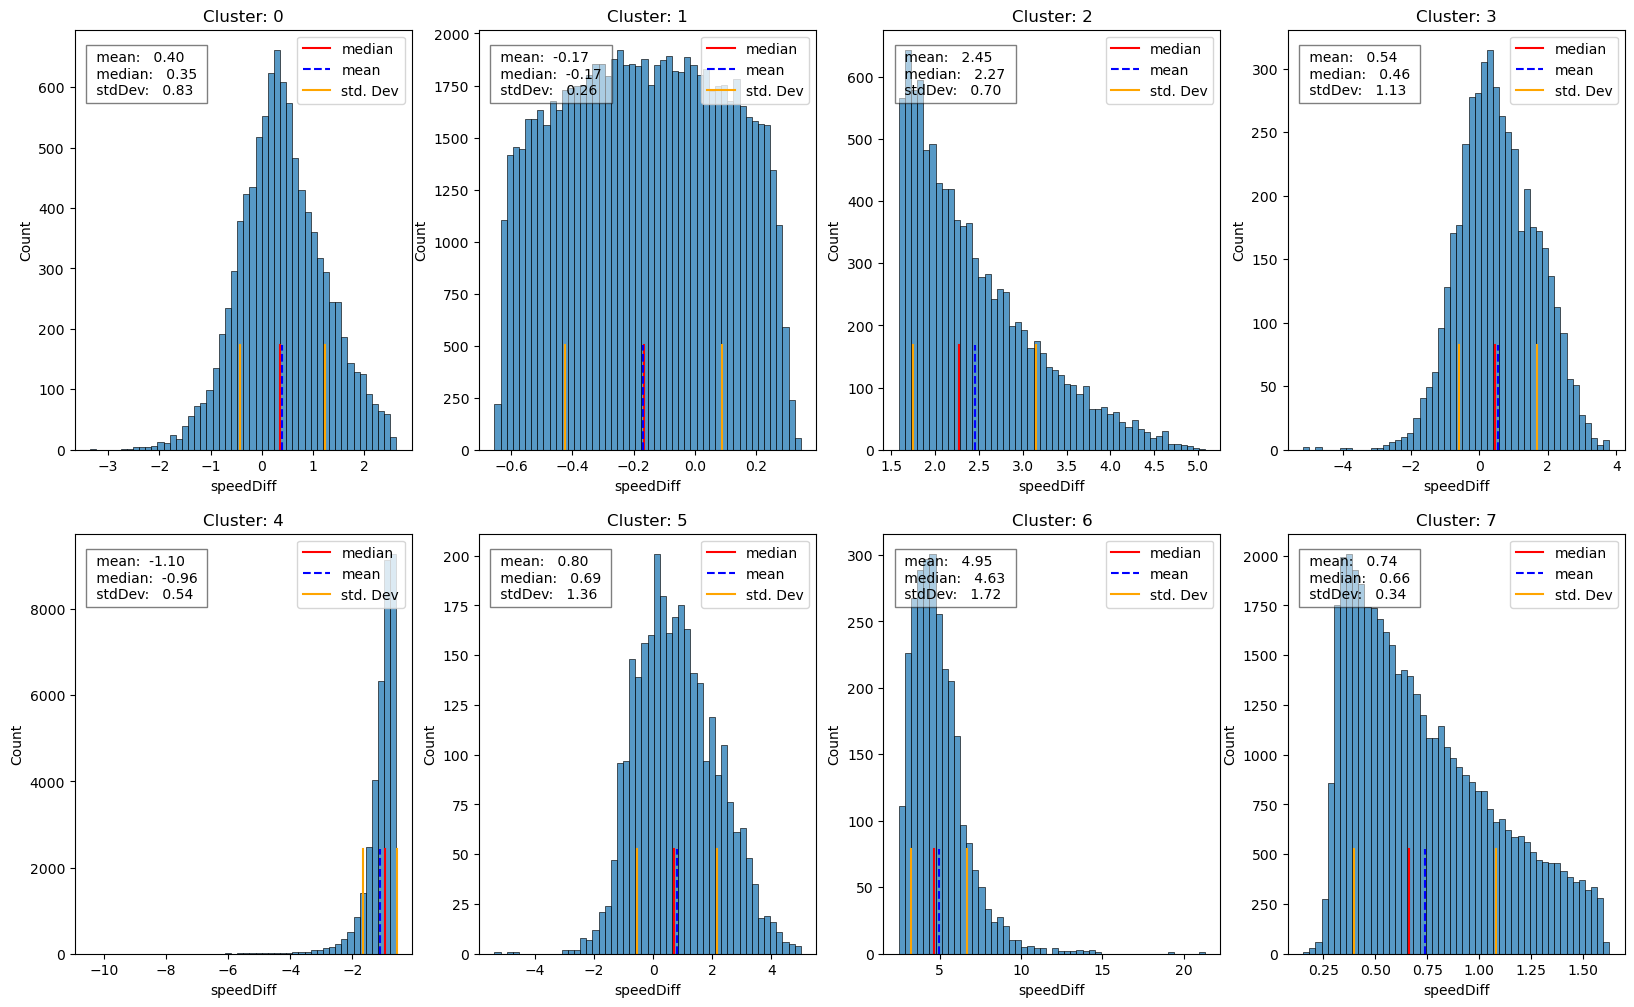

In [83]:
var = 'speedDiff'

medians = df.groupby(['label'])[var].median()
means = df.groupby(['label'])[var].mean()
stdDevs = df.groupby(['label'])[var].std()

fig,  axes = plt.subplots(nrows=2, ncols=4, figsize=(20,12))

for labelVal in range(8):
    ii = int(labelVal//4)
    jj = labelVal%4
    print(ii, jj)
    ax = axes[ii,jj]
    getPDFplotFor(ax, df, labelVal, var)
    ax.set_title('Cluster: '+ str(labelVal))
    

0 0
0 1
0 2
0 3
1 0


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option i

1 1
1 2
1 3


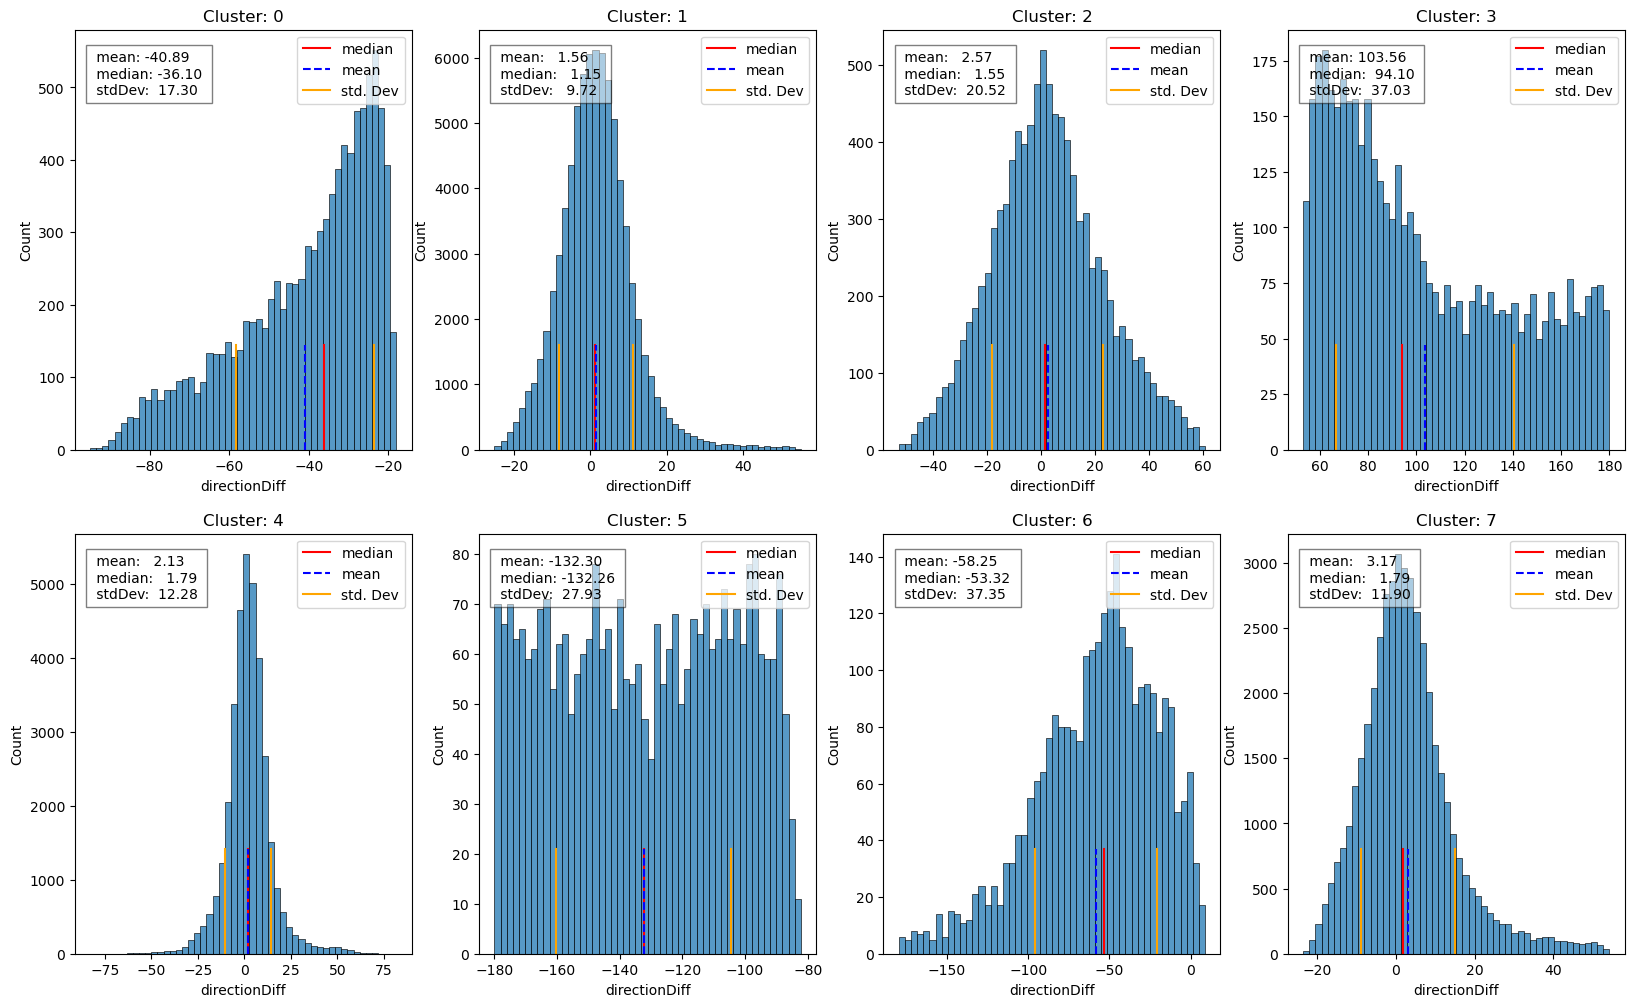

In [84]:
var = 'directionDiff'

medians = df.groupby(['label'])[var].median()
means = df.groupby(['label'])[var].mean()
stdDevs = df.groupby(['label'])[var].std()

fig,  axes = plt.subplots(nrows=2, ncols=4, figsize=(20,12))

for labelVal in range(8):
    ii = int(labelVal//4)
    jj = labelVal%4
    print(ii, jj)
    ax = axes[ii,jj]
    getPDFplotFor(ax, df, labelVal, var)
    ax.set_title('Cluster: '+ str(labelVal))


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0.5, 0, 'cluster label')

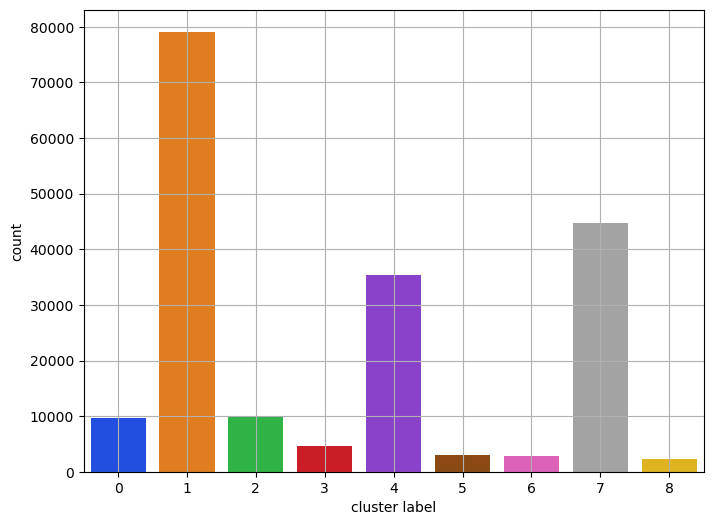

In [35]:
fig,  ax = plt.subplots(figsize=(8,6))
xlabel = 'speedDiff'
ylabel = 'directionDiff'
s = sns.countplot(df, x='label',palette = sns.color_palette("bright"), ax = ax)

ax.grid(visible=True, which='both', axis='both')
ax.set_xlabel('cluster label')
#ax.set_ylabel('cluster label')

In [39]:
goodBad = np.array(['good' for i in range(len(df))])
print(len(goodBad))
mask = df['label'].isin([0,2,3,5,6,8])
goodBad[mask] = 'bad'
df['GoodBad'] = goodBad



191714


In [90]:
def getGoodBad(lat, lon, df):
    LAT = lat
    LON = lon

    if lat < 0:
        latUnits = 'S'
    else:
        latUnits = 'N'

    if lon < 0:
        lonUnits = 'W'
        LON += 360
    else:
        lonUnits = 'E'
    
    lat=abs(lat)
    lon=abs(lon)

    matchFname = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_matchupNearestFour_2000.nc'
    deployFileName = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_DeploymentDates.nc'
    
    if os.path.isfile(matchFname):
        subDF = df.loc[df['lat'] == LAT]
        subDF = subDF.loc[subDF['lon'] == LON]
        goodCount = len(subDF.loc[subDF['GoodBad'] == 'good'])/len(subDF)*100
        badCount = len(subDF.loc[subDF['GoodBad'] == 'bad'])/len(subDF)*100
        

        return f' {goodCount:3.0f},{badCount:3.0f}'
    else:
        return ''
    

In [91]:
getGoodBad(0, -140, df), getGoodBad(2, -140, df), 

('  96,  4', '  96,  4')

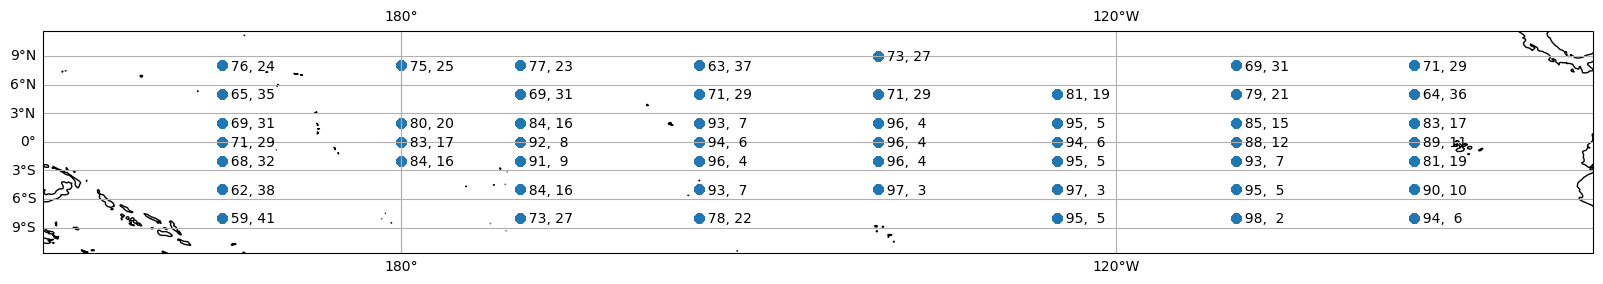

In [98]:
import cartopy.crs as ccrs
import cartopy.feature as creature 
fig, ax = plt.subplots(nrows = 1, 
                       ncols = 1, 
                        figsize = (20,3),
                       subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180), "aspect": 0.8},
                       gridspec_kw = {'wspace':0.2, 'hspace':0.5}) 

#ax = axes[0]
for task in taskList:
    lat = task[0]
    lon = task[1]
    txt = getGoodBad(lat, lon, df)

    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    ax.text(xpos, lat-0.5, txt)
    
ax.set_extent([150, -80, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.scatter(df['lon'], df['lat'], transform=ccrs.PlateCarree())
ax.coastlines()


    


In [104]:
cdfDates = num2date(df['time'], 'seconds since 1990-01-01 00:00:00')
dateTime = np.array([datetime(cdf.year, cdf.month, cdf.day, cdf.hour, cdf.minute) for cdf in cdfDates])
df['dateTime'] = dateTime

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

Text(0.5, 1.0, 'For Buoy locations lon > -120 E ')

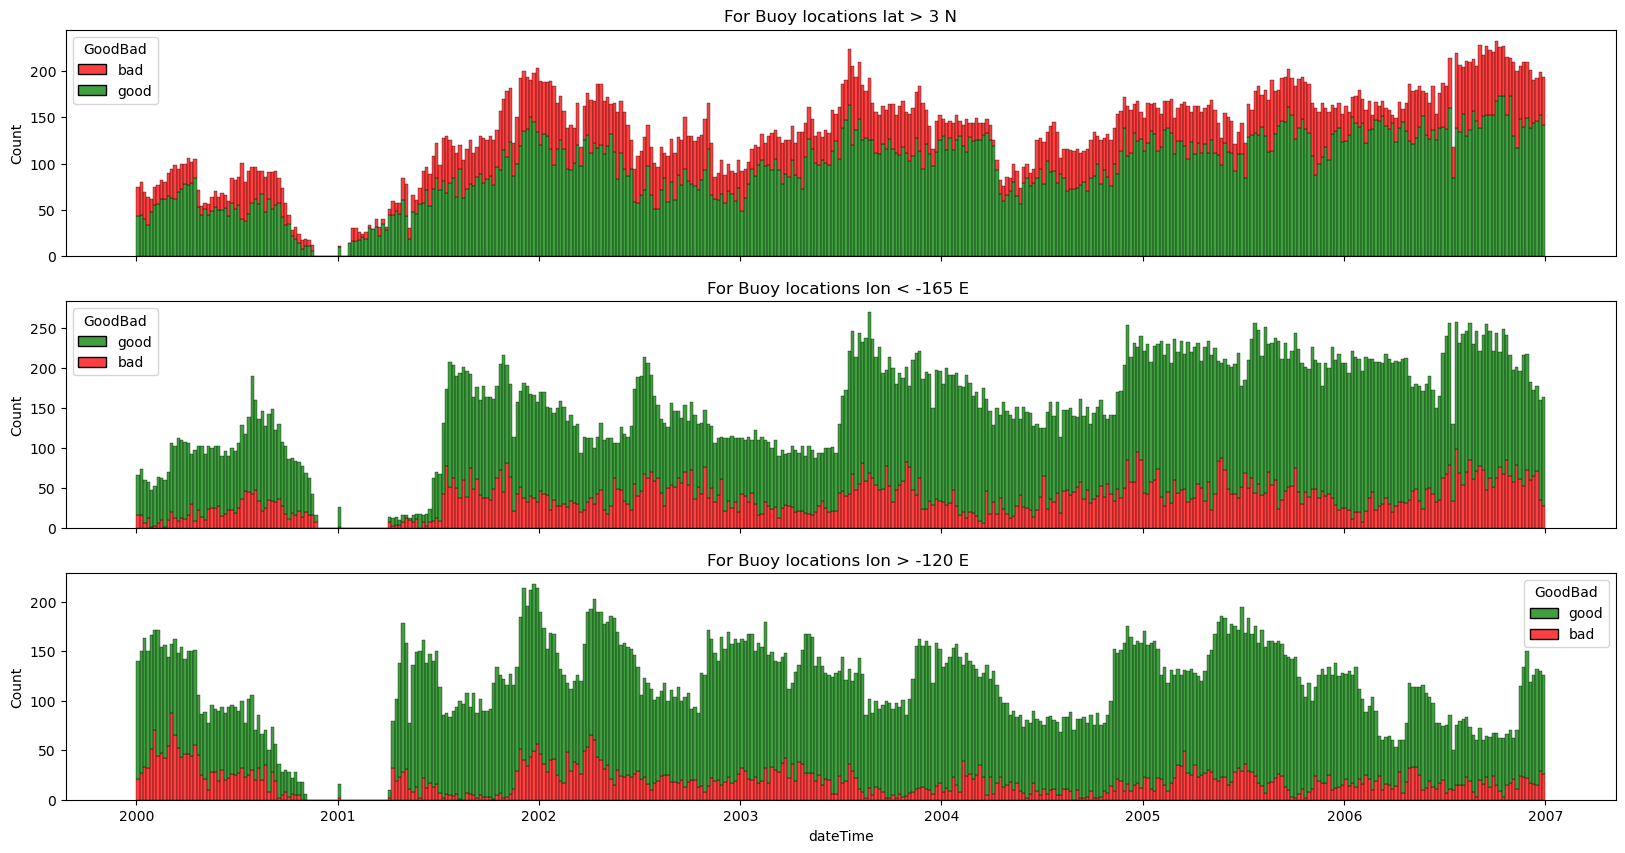

In [162]:
fig, axes = plt.subplots(nrows=3, ncols =1, sharex = True, figsize=(20,10))

cmap = plt.get_cmap('jet').copy()
cmap.set_bad('white')
nx = 12*7*5 # 168
ny = 10

title = 'For Buoy locations lat > 3 N'
ax = axes[0]
subDF = df.loc[df['lat'] > 3]
goodDF = subDF.loc[subDF['GoodBad'] == 'good']
badDF = subDF.loc[subDF['GoodBad'] == 'bad']

#sns.kdeplot(badDF, x = 'dateTime', y='speedDiff', linewidths=0.5, color='red', ax = ax)
# sns.histplot(
#     badDF,  x = 'dateTime', y='speedDiff',
#     bins=nx, discrete=(True, True),# log_scale=(False, True),
#     cbar=True, cbar_kws=dict(shrink=.75), color = 'purple', ax = ax
# )

sns.histplot(subDF, x='dateTime', bins= nx, hue='GoodBad',  multiple="stack", palette = {'good': 'green', 'bad': 'red'}, ax = ax)
ax.set_title(title)
# sns.scatterplot(badDF,  x = 'dateTime', y='speedDiff', ax = ax, s = 0.)

title = 'For Buoy locations lon < -165 E '
ax = axes[1]
subDF = df.loc[df['lon'] < (360-165)]
goodDF = subDF.loc[subDF['GoodBad'] == 'good']
badDF = subDF.loc[subDF['GoodBad'] == 'bad']

#sns.kdeplot(badDF, x = 'dateTime', y='speedDiff', linewidths=0.5, color='red', ax = ax)
# sns.histplot(
#     badDF,  x = 'dateTime', y='speedDiff',
#     bins=nx, discrete=(True, True),# log_scale=(False, True),
#     cbar=True, cbar_kws=dict(shrink=.75), ax = ax
# )
sns.histplot(subDF, x='dateTime', bins= nx, hue='GoodBad',  multiple="stack", palette = {'good': 'green', 'bad': 'red'}, ax = ax)
ax.set_title(title)

title = 'For Buoy locations lon > -120 E '
ax = axes[2]
subDF = df.loc[df['lon'] > (360-120)]
goodDF = subDF.loc[subDF['GoodBad'] == 'good']
badDF = subDF.loc[subDF['GoodBad'] == 'bad']

# sns.kdeplot(badDF, x = 'dateTime', y='speedDiff', linewidths=0.5, color='red', ax = ax)
# sns.histplot(
#     badDF,  x = 'dateTime', y='speedDiff',
#     bins=nx, discrete=(True, True),
#     cbar=True, cbar_kws=dict(shrink=.75), ax = ax
# )
sns.histplot(subDF, x='dateTime', bins= nx, hue='GoodBad', multiple="stack",  palette = {'good': 'green', 'bad': 'red'}, ax = ax)
ax.set_title(title)

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

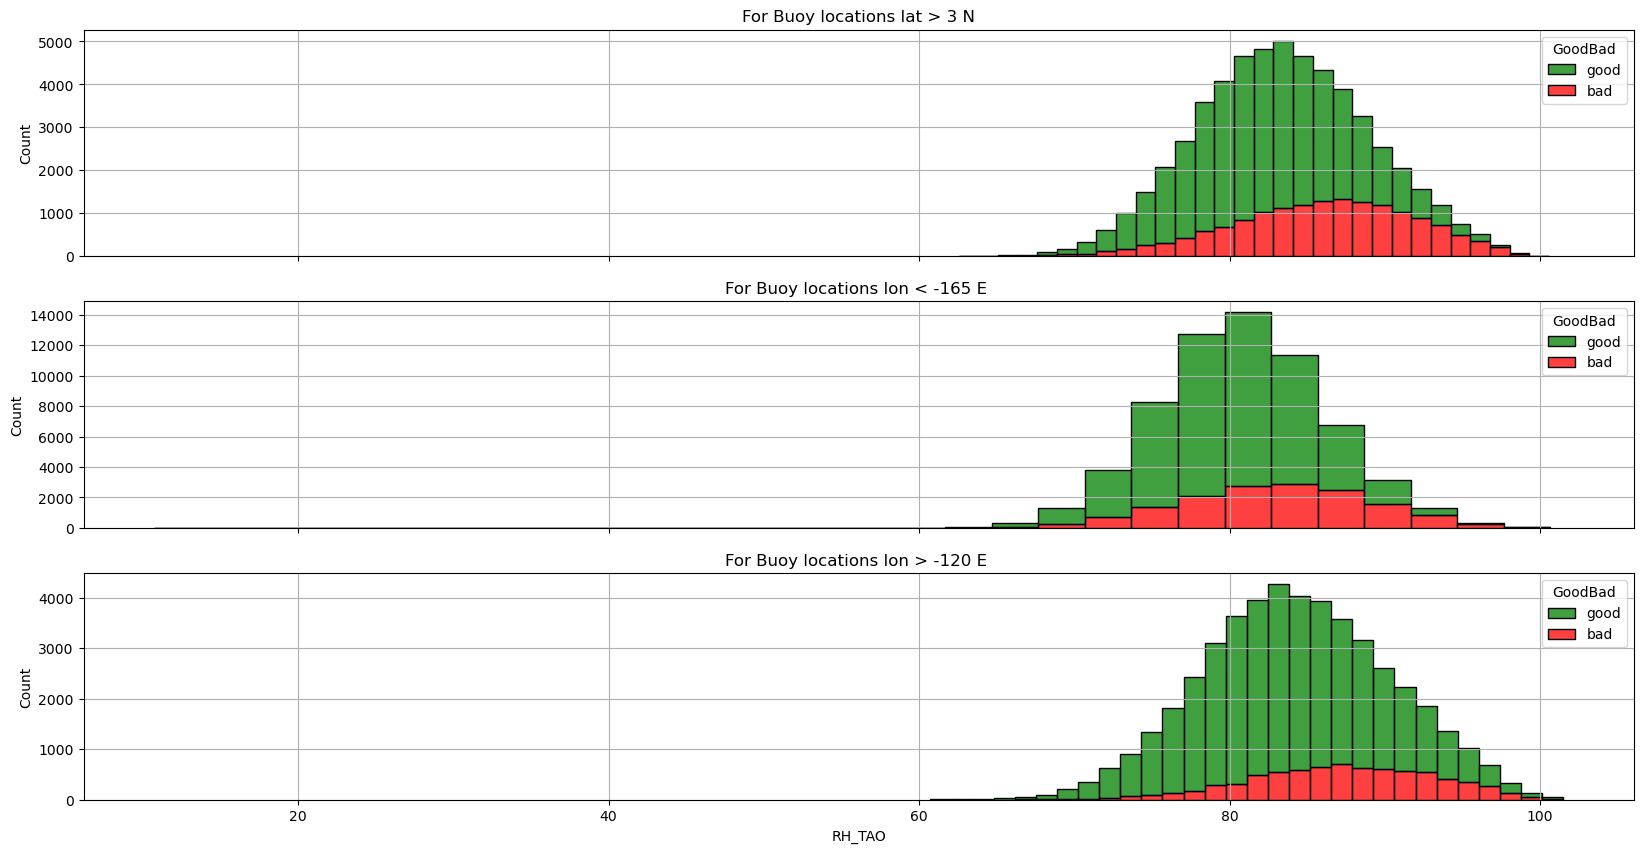

In [179]:
fig, axes = plt.subplots(nrows=3, ncols =1, sharex = True, figsize=(20,10))

cmap = plt.get_cmap('jet').copy()
cmap.set_bad('white')
nx = 30 #12*7*5 # 168
ny = 10

xlabel = 'RH_TAO'
title = 'For Buoy locations lat > 3 N'
ax = axes[0]
subDF = df.loc[df['lat'] > 3]
goodDF = subDF.loc[subDF['GoodBad'] == 'good']
badDF = subDF.loc[subDF['GoodBad'] == 'bad']

#sns.kdeplot(badDF, x = 'dateTime', y='speedDiff', linewidths=0.5, color='red', ax = ax)
# sns.histplot(
#     badDF,  x = 'dateTime', y='speedDiff',
#     bins=nx, discrete=(True, True),# log_scale=(False, True),
#     cbar=True, cbar_kws=dict(shrink=.75), color = 'purple', ax = ax
# )

sns.histplot(subDF.iloc[::-1], x=xlabel, bins= nx, hue='GoodBad',  multiple="stack", palette = {'good': 'green', 'bad': 'red'}, ax = ax)
ax.set_title(title)
ax.grid(visible=True, which='major')
# sns.scatterplot(badDF,  x = 'dateTime', y='speedDiff', ax = ax, s = 0.)

title = 'For Buoy locations lon < -165 E '
ax = axes[1]
subDF = df.loc[df['lon'] < (360-165)]
goodDF = subDF.loc[subDF['GoodBad'] == 'good']
badDF = subDF.loc[subDF['GoodBad'] == 'bad']

#sns.kdeplot(badDF, x = 'dateTime', y='speedDiff', linewidths=0.5, color='red', ax = ax)
# sns.histplot(
#     badDF,  x = 'dateTime', y='speedDiff',
#     bins=nx, discrete=(True, True),# log_scale=(False, True),
#     cbar=True, cbar_kws=dict(shrink=.75), ax = ax
# )
sns.histplot(subDF, x=xlabel, bins= nx, hue='GoodBad',  multiple="stack", palette = {'good': 'green', 'bad': 'red'}, ax = ax)
ax.set_title(title)
ax.grid(visible=True, which='major')

title = 'For Buoy locations lon > -120 E '
ax = axes[2]
subDF = df.loc[df['lon'] > (360-120)]
goodDF = subDF.loc[subDF['GoodBad'] == 'good']
badDF = subDF.loc[subDF['GoodBad'] == 'bad']

# sns.kdeplot(badDF, x = 'dateTime', y='speedDiff', linewidths=0.5, color='red', ax = ax)
# sns.histplot(
#     badDF,  x = 'dateTime', y='speedDiff',
#     bins=nx, discrete=(True, True),
#     cbar=True, cbar_kws=dict(shrink=.75), ax = ax
# )
sns.histplot(subDF, x=xlabel, bins= nx, hue='GoodBad', multiple="stack",  palette = {'good': 'green', 'bad': 'red'}, ax = ax)
ax.set_title(title)
#ax.set_xlabel('TAO zonal Wind')
ax.grid(visible=True, which='major')

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4,4), sharey=False)
    
#ax = axes[0,0]
cmap = plt.get_cmap('Greys').copy()
cmap.set_bad('white')
h1 = ax.hist2d(subDF[xlabel], subDF[ylabel], bins=[50, 50], cmap=cmap, 
                   norm=colors.LogNorm())
s = sns.kdeplot(subDF, x=xlabel, y=ylabel,
                levels=20, linewidths=0.5, 
                palette = sns.color_palette("bright"), ax = ax)

xmin, xmax = subDF[xlabel].min(), subDF[xlabel].max()
ymin, ymax = subDF[ylabel].min(), subDF[ylabel].max()

xrange = (xmax - xmin)
xtol = 0.1 * xrange

yrange = (ymax - ymin)
ytol = 0.1 * yrange

xmin -= xtol
xmax += xtol

ymin -= ytol
ymax += ytol


ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
plt.colorbar(h1[3], ax = ax)
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)

In [ ]:
xlabel = 'speedDiff'
ylabel = 'directionDiff'
nx = 100
ny = 100
fig, ax = plt.subplots(figsize=(10,10))
cmap = plt.get_cmap('Greys').copy()
cmap.set_bad('white')

subDF = df.loc[df['label'].isin([0,2,3,5])]#,6,8])]

h1 = ax.hist2d(subDF[xlabel], subDF[ylabel], bins=[nx, ny], cmap=cmap, 
                   norm=colors.LogNorm())
s = sns.kdeplot(subDF, x=xlabel, y=ylabel, common_norm=False,
                hue='label',levels=20, linewidths=0.5, 
                palette = sns.color_palette("bright"), ax = ax)

xmin, xmax = subDF[xlabel].min(), subDF[xlabel].max()
ymin, ymax = subDF[ylabel].min(), subDF[ylabel].max()

xrange = (xmax - xmin)
xtol = 0.1 * xrange

yrange = (ymax - ymin)
ytol = 0.1 * yrange

xmin -= xtol
xmax += xtol

ymin -= ytol
ymax += ytol


ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
plt.colorbar(h1[3], ax = ax)

In [ ]:
# xlabel = 'speedDiff'
# ylabel = 'directionDiff'
# s = sns.kdeplot(df, x=xlabel, y = ylabel,levels=10, 
#                 hue='label', #common_norm=False,
#                 palette = sns.color_palette("bright"))

In [ ]:
def pdfPlotTest(xlabel, ylabel, subDF, nx = 50, ny =50):
    fname = f'{xlabel}_{ylabel}_density.png'
    
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10,3), sharey=True)
    
    ax = axes[0]
    s = sns.kdeplot(subDF, x=xlabel, y=ylabel, 
                    hue='label',levels=20, thres=0.1, linewidths=0.5, 
                    palette = sns.color_palette("bright"), ax = ax)

    ssubDF = subDF.loc[subDF['label'] == 0]
    ax = axes[1]
    h1 = ax.hist2d(ssubDF[xlabel], ssubDF[ylabel], bins=[nx, ny], cmap=plt.get_cmap('Reds'))
    s = sns.kdeplot(ssubDF, x=xlabel, y=ylabel, 
                    levels=5, thres=0.1, linewidths=0.5, 
                    color = sns.color_palette("bright")[0], ax = ax)
    ax.set_xlabel(xlabel)
    ax.set_xlim(axes[0].get_xlim())
    plt.colorbar(h1[3], ax = ax)
    

    ssubDF = subDF.loc[subDF['label'] == 1]
    ax = axes[2]
    h2 = ax.hist2d(ssubDF[xlabel], ssubDF[ylabel], bins=[nx, ny], cmap=plt.get_cmap('Reds'))
    s = sns.kdeplot(ssubDF, x=xlabel, y=ylabel, 
                    levels=5, thres=0.1, linewidths=0.5, 
                    color = sns.color_palette("bright")[1], ax = ax)
    ax.set_xlabel(xlabel)
    ax.set_xlim(axes[0].get_xlim())
    plt.colorbar(h2[3], ax = ax)

    ssubDF = subDF.loc[subDF['label'] == 2]
    ax = axes[3]
    h3 = ax.hist2d(ssubDF[xlabel], ssubDF[ylabel], bins=[nx, ny], cmap=plt.get_cmap('Reds'))
    s = sns.kdeplot(ssubDF, x=xlabel, y=ylabel, 
                    levels=5, thres=0.1, linewidths=0.5, 
                    color = sns.color_palette("bright")[2], ax = ax)
    ax.set_xlabel(xlabel)
    ax.set_xlim(axes[0].get_xlim())
    plt.colorbar(h3[3], ax = ax)

    plt.subplots_adjust(left = 0.1, right=0.95, top = 0.95, bottom=0.15, wspace=0.2)
    fig.savefig(fname, dpi = 100)
    #plt.close()

In [148]:
arr = np.random.randint(1, 100, size=1000)
mask = arr%3 == 0
a = np.empty((1000), dtype='object')
a[mask] = 'good'
a[~mask] = 'bad'
testDF = pd.DataFrame({'val': arr, 'label': a})

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

<Axes: xlabel='val', ylabel='Count'>

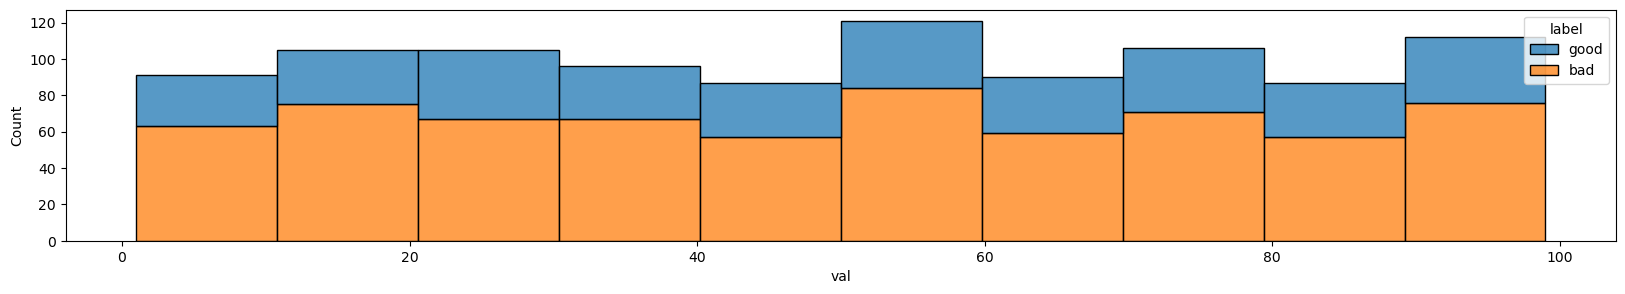

In [156]:
plt.figure(figsize=(20,3))
sns.histplot(testDF, x='val', bins=10, hue='label', multiple="stack")

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='val', ylabel='Count'>

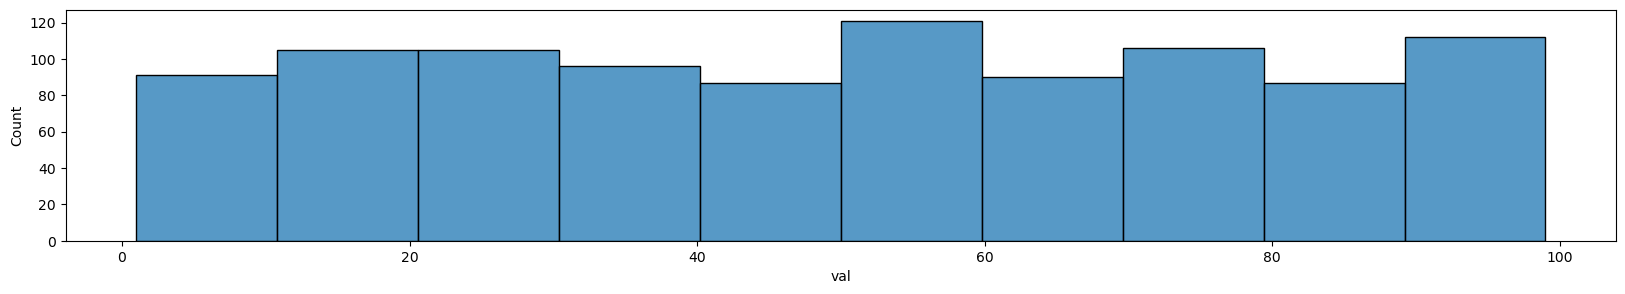

In [155]:
plt.figure(figsize=(20,3))
sns.histplot(testDF, x='val', bins=10)

In [ ]:
def pdfPlotTest(xlabel, ylabel, subDF, nx = 50, ny =50):
    fname = f'{xlabel}_{ylabel}_density_errorsOnly_of_each_cluster.png'
    
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20,8), sharey=False)
    
    ax = axes[0,0]
    cmap = plt.get_cmap('Greys').copy()
    cmap.set_bad('white')
    h1 = ax.hist2d(subDF[xlabel], subDF[ylabel], bins=[nx, ny], cmap=cmap, 
                       norm=colors.LogNorm())
    s = sns.kdeplot(subDF, x=xlabel, y=ylabel, common_norm=False,
                    hue='label',levels=20, linewidths=0.5, 
                    palette = sns.color_palette("bright"), ax = ax)

    xmin, xmax = subDF[xlabel].min(), subDF[xlabel].max()
    ymin, ymax = subDF[ylabel].min(), subDF[ylabel].max()
    
    xrange = (xmax - xmin)
    xtol = 0.1 * xrange

    yrange = (ymax - ymin)
    ytol = 0.1 * yrange

    xmin -= xtol
    xmax += xtol

    ymin -= ytol
    ymax += ytol


    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    plt.colorbar(h1[3], ax = ax)
    ax.set_xlabel(None)
    
    
    for i in range(1,10):
        ii = int(i//5)
        jj = int(i%5)
        ssubDF = subDF.loc[subDF['label'] == i-1]
        ax = axes[ii, jj]
        h1 = ax.hist2d(ssubDF[xlabel], ssubDF[ylabel], bins=[nx, ny], cmap=plt.get_cmap('Greys'), 
                       norm=colors.LogNorm())
        s = sns.kdeplot(ssubDF, x=xlabel, y=ylabel, 
                        levels=10, linewidths=0.5, 
                        color = 'Red', ax = ax)
        if ii == 1:
            ax.set_xlabel(xlabel)
        else:
            ax.set_xlabel(None)

        if jj == 0:
            ax.set_ylabel(ylabel)
        else:
            ax.set_ylabel(None)
            
        xmin, xmax = ssubDF[xlabel].min(), ssubDF[xlabel].max()
        ymin, ymax = ssubDF[ylabel].min(), ssubDF[ylabel].max()
        
        xrange = (xmax - xmin)
        xtol = 0.1 * xrange
    
        yrange = (ymax - ymin)
        ytol = 0.1 * yrange
    
        xmin -= xtol
        xmax += xtol
    
        ymin -= ytol
        ymax += ytol
        
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)
        ax.set_title(f'label = {i-1:d}')
        plt.colorbar(h1[3], ax = ax)
    

    plt.subplots_adjust(left = 0.1, right=0.95, top = 0.95, bottom=0.15, wspace=0.2)
    fig.savefig(fname, dpi = 100)
    #plt.close()

In [ ]:
pdfPlotTest('speedDiff', 'directionDiff', df, nx = 50, ny =50)

In [ ]:
sns.kdeplot(subDF, x='speedDiff', y='directionDiff', 
                    hue='label',levels=20, linewidths=0.5, 
                    palette = sns.color_palette("bright"))

In [ ]:
for i in range(len(subDFheaders)-1):
    for j in range(i+1, len(subDFheaders)):
        xlabel = subDFheaders[i]
        ylabel = subDFheaders[j]:
        if xlabel != ylabel:
            print(xlabel, ylabel)
            pdfPlotTest(xlabel, ylabel, subDF)

In [ ]:
testDF = df.loc[df['label'] == 1]
testDF.head()

In [ ]:
def pdfPlot1d(subDF, var):
    fname = f'{var}_density.png'
    fig, ax = plt.subplots(figsize=(10,6))
    s = sns.kdeplot(subDF, x=var, hue='label', ax=ax)
    fig.savefig(fname, dpi = 100)
    plt.close()

In [ ]:
for xlabel in subDFheaders:
    print(xlabel)
    pdfPlot1d(subDF, xlabel)

In [ ]:
sns.kdeplot(subDF, x='speedDiff', y='directionDiff', hue='label', levels=20)

In [ ]:
sns.kdeplot(df, x='absSpeedDiff', y='absDirectionDiff', hue='label', levels=20)